In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../CSV'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

../CSV/Democracy-Dictatorship_Index.csv
../CSV/World_Happiness_Report.csv
../CSV/Population_by_Country_2020.csv
../CSV/World_Happiness_Report_2021.csv
../CSV/Life_Expectancy.csv
../CSV/Country_Population.csv
../CSV/Fertility_Rate.csv


In [2]:
#Download Data from Github

whr = pd.read_csv('/kaggle/input/world-happiness-report-2021/world-happiness-report-2021.csv')
population = pd.read_csv('/kaggle/input/population-by-country-2020/population_by_country_2020.csv')
country_codes = pd.read_csv('../input/world-bank-data-1960-to-2016/country_population.csv')
political_regime = pd.read_csv('../input/democracy-dictatorship-index/Democracy-Dictatorship_Index.csv')
#print('DF loaded')

# HAPPINESS, POLITICS AND POPULATION

# World happiness research
The idea of my survey is to find out the reasons of people happiness.
Along with the analysing the correlation between happiness level and 6 major factors,chosen by world happiness report, 
I am going to add 2 new factors : politic regime and total population.

The World Happiness Report marks countries on 6 life evaluated factors have no impact on the total score reported for each country, 
they are just a way of explaining for each country the implications of the happiness score.

This study is going to find out, explain and visualize happiness level of nations via coherence  with political regime  and population.

***
**3 dataframes are using in  this research:**
 - World Happiness Report 2021
 - Population by country 2020
 - Democracy-dictatorship index

***

**"Country name"** column is chosen as a key-column to all data frames. 

As  there are a mismatch in countries names in different reports we have to preprocess data: rename countries and fill up the missing values. 

***

In [3]:
########################Preprocessing df Population

pop = population[['Country (or dependency)', 'Population (2020)','Fert. Rate', 'Med. Age', 'Urban Pop %']]
pop = pop.rename(columns = {'Country (or dependency)':'Country name', 'Population (2020)': 'Population2020' })

pop['UrbanPop%'] = pop['Urban Pop %'].str.replace('%','')
pop[pop['Urban Pop %'] == 'N.A.'] = pop[pop['Urban Pop %'] == 'N.A.'].replace({'UrbanPop%':'N.A.'},999)
pop['UrbanPop%'] = pd.to_numeric(pop['UrbanPop%'])

pop[pop['Country name'] == 'Venezuela'] = pop[pop['Country name'] == 'Venezuela'].replace({'UrbanPop%':999},88)
pop[pop['Country name'] == 'Hong Kong'] = pop[pop['Country name'] == 'Hong Kong'].replace({'UrbanPop%':999},100)
pop[pop['Country name'] == 'Singapore'] = pop[pop['Country name'] == 'Singapore'].replace({'UrbanPop%':999},100)
pop[pop['Country name'] == 'Kuwait'] = pop[pop['Country name'] == 'Kuwait'].replace({'UrbanPop%':999},100)


#Rename county name in Population dataset = 9
#['Congo (Brazzaville)', 'Czech Republic', 'Hong Kong S.A.R. of China', 'Ivory Coast', #'Kosovo', 'North Cyprus',
#'Palestinian Territories', 'Swaziland', 'Taiwan Province of China']

countries_rename = {'Czech Republic (Czechia)':'Czech Republic',
                    'Hong Kong':'Hong Kong S.A.R. of China',
                    'DR Congo' : 'Congo (Brazzaville)',
                    "Côte d'Ivoire": 'Ivory Coast',
                    'State of Palestine':'Palestinian Territories',
                    'Eswatini':'Swaziland',
                    'Taiwan':'Taiwan Province of China'}
                 
for key, value in countries_rename.items():
    pop['Country name']  = pop['Country name'].replace({key:value})
    
    
#Add new Countries Popul from https://www.cia.gov/the-world-factbook/field/population фтв
#add info KOsovo - https://www.indexmundi.com/kosovo/demographics_profile.html
pop = pop.append({'Country name':'North Cyprus', 'Population2020': 326000, 
                              'Fert. Rate': 1.3, 'Med. Age':37  , 'UrbanPop%': 67
                              }, ignore_index = True)
pop = pop.append({'Country name': 'Kosovo',  'Population2020': 1932774,
                             'Fert. Rate': 1.95, 'Med. Age':30.5  , 'UrbanPop%': 38
                             }, ignore_index = True)

#minus population of Noth Cyprus  from Cypus
pop[pop['Country name'] == 'Cyprus'] = pop[pop['Country name'] == 'Cyprus'].replace({'Population2020':1208886},881361)

#add urban rural population in mln people
pop['UrbanPopMln'] = (pop['Population2020']/1000000 * (pop['UrbanPop%']/100)).round(3)
pop['RuralPopMln'] = (pop['Population2020']/1000000 - pop['UrbanPopMln']).round(3)

pop = pop[['Country name','Population2020', 'UrbanPop%','UrbanPopMln','RuralPopMln','Fert. Rate', 'Med. Age']]


#########Preprocessing Country codes

codes = country_codes [['Country Name', 'Country Code']]
codes = codes.rename(columns = {'Country Name':'Country name', 'Country Code': 'Country code'})

#Change county name in codes
#['Congo (Brazzaville)', 'Egypt', 'Gambia', 'Hong Kong S.A.R. of China', 'Iran', 'Ivory Coast', 'Kyrgyzstan', 'Laos', 
###'North Cyprus',#### 'Taiwan Province of China',###
#'North Macedonia','Palestinian Territories', 'Russia', 'Slovakia', 'South Korea', 'Venezuela', 'Yemen']

df =codes
countries_names = {'Congo, Rep.' : 'Congo (Brazzaville)', 
                   'Egypt, Arab Rep.' : 'Egypt',
                   'Gambia, The': 'Gambia',
                   'Hong Kong SAR, China':'Hong Kong S.A.R. of China',
                   'Iran, Islamic Rep.': 'Iran',
                   "Cote d'Ivoire": 'Ivory Coast',  
                   'Kyrgyz Republic':'Kyrgyzstan',
                   'Lao PDR': 'Laos',
                   'Macedonia, FYR' : 'North Macedonia', 
                   'West Bank and Gaza':'Palestinian Territories',
                   'Russian Federation': 'Russia',   
                   'Slovak Republic': 'Slovakia',
                   'Korea, Rep.': 'South Korea',
                   'Venezuela, RB': 'Venezuela',
                   'Yemen, Rep.': 'Yemen'    
                  }
for key, value in countries_names.items():
    df['Country name']  = df['Country name'].replace({key:value})

    
#add codes ['North Cyprus', 'Taiwan Province of China']
codes = codes.append({'Country name':'North Cyprus', 'Country code':'TRNC'}, ignore_index = True)
codes = codes.append({'Country name': 'Taiwan Province of China','Country code': 'TWN'}, ignore_index = True)   


######Preprocessing  df Political Regime

regime = political_regime[['Regime', 'Type', 'Subtype']]
regime = regime.rename(columns ={'Regime': 'Country code'})

#add country names to regime (politics) from  codes
regime = pd.merge(regime, codes, how='left', on= 'Country code')



#ADD DAta ['Hong Kong S.A.R. of China', 'Kosovo', 'North Cyprus', 'Palestinian Territories']
#Source  = The Economist Intelligence Unit 

regime = regime.append({ 'Country code': 'XKX', 'Type': 'Democracy', 'Subtype': 'Parliamentary Democracy',\
                  'Reason for Dictatorship': 'noData', 'Country name': 'Kosovo'}, ignore_index = True)
                
regime = regime.append({ 'Country code': 'HKG', 'Type': 'Democracy', 'Subtype': 'Parliamentary Democracy',\
                  'Reason for Dictatorship': 'noData', 'Country name': 'Hong Kong S.A.R. of China'}, ignore_index = True)

regime = regime.append({ 'Country code': 'TRNC', 'Type': 'Democracy', 'Subtype': 'Semi-Presidential Democracy',\
                  'Reason for Dictatorship': 'noData', 'Country name': 'North Cyprus'}, ignore_index = True)

regime = regime.append({ 'Country code': 'PSE', 'Type': 'Dictatorship', 'Subtype': 'Civilian Dictatorship',\
                  'Reason for Dictatorship': 'noData', 'Country name': 'Palestinian Territories'}, ignore_index = True)

In [4]:
# First of all let  choose valuable columns = 6 factors and create new dataset for analyse
maincols = ['Country name','Regional indicator', 'Ladder score', \
       'Logged GDP per capita', 'Social support', 'Healthy life expectancy', \
       'Freedom to make life choices', 'Generosity', 'Perceptions of corruption' ]

factors = ['Ladder score', \
       'Logged GDP per capita', 'Social support', 'Healthy life expectancy', \
       'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']

data = whr[maincols].copy()

#data.shape


#COLOURS AND FONTS FOR ALL TEXT

#sz_head = 18 #fontsize of heads
#sz_txt = 14 #fontsize of main text
#sz_com = 14 #fontsize of comments
#w_head = 'bold' #fontweight of head

In [5]:
## Let's find put MEANS=AVERAGES VALUES FOR ALL DATA & Min Max val for Score ---  Type ==float

mean_score = data['Ladder score'].mean()  #<== 5.532838926174494    
max_score = data['Ladder score'].max()     # <== 7.8420000000000005
min_score = data['Ladder score'].min()     # <== 2.523
mean_gdp = data['Logged GDP per capita'].mean() #<== 9.432208053691275
mean_support = data['Social support'].mean()        #<== 0.8147449664429529
mean_health = data['Healthy life expectancy'].mean()   #<==  64.99279865771811
mean_freedom = data['Freedom to make life choices'].mean() #<==  0.7915973154362413
mean_generosity = data['Generosity'].mean()                  #<== -0.015134228187919468
mean_corruption = data['Perceptions of corruption'].mean()       #<==  0.7274496644295301

#To analyse the differences between those who are happy and who are not
#Let's devide all countries into 2 groups: 
#1 - with happiness score above average > 5.5328 and 2 - whoes happiness level is below average score
data['groupby meanscore'] = data['Ladder score'].map(lambda x: 2 if x < mean_score else 1)
#data.shape

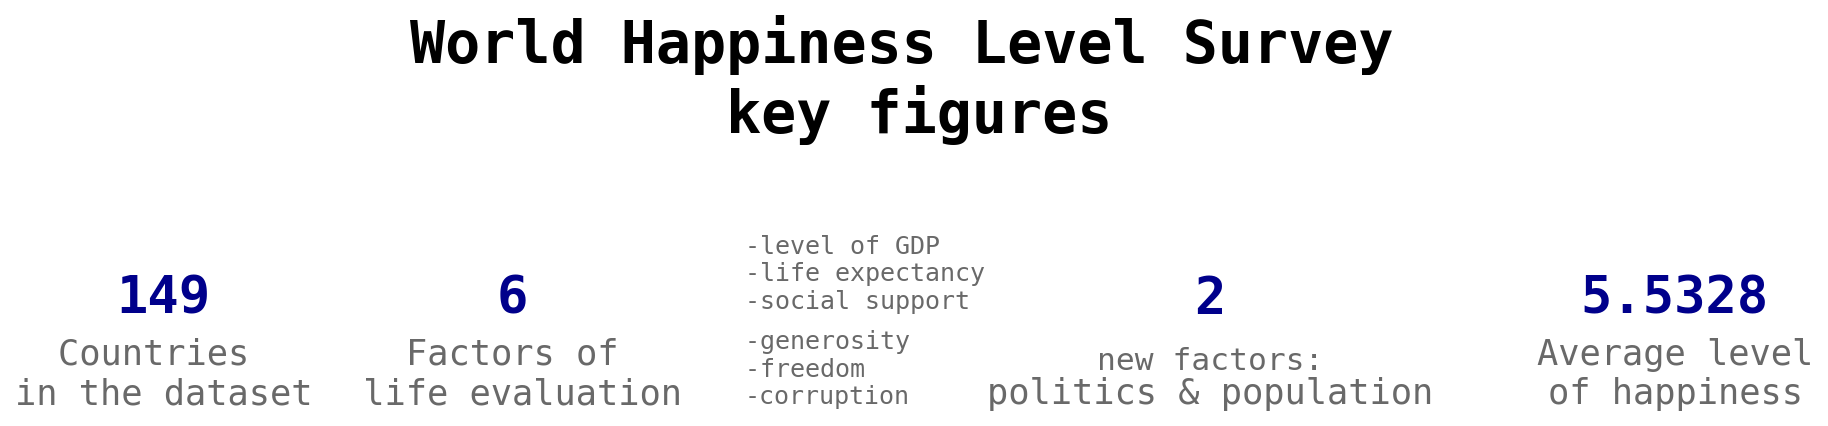

In [6]:
# General overview of data

fig=plt.figure(figsize=(5,2),dpi=150,facecolor='white')

num_clr = 'darkblue' #'gold'
txt_clr = 'dimgrey'

ax0=fig.add_subplot(1,1,1)
ax0.text(1.3,1.2,"World Happiness Level Survey \nkey figures",
         color='black',fontsize=28, fontweight='bold', fontfamily='monospace', ha='center')

ax0.text(0,0.4, "149",color=num_clr ,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(0,0.001,"Countries \nin the dataset",color=txt_clr,fontsize=17, fontweight='light', fontfamily='monospace',ha='center')


ax0.text(0.6,0.4,"6",color=num_clr ,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(0.6,0.001,"Factors of\n life evaluation",color=txt_clr,fontsize=17, fontweight='light', fontfamily='monospace',ha='center')


ax0.text(1.0,0.42,"-level of GDP \n-life expectancy \n-social support",color=txt_clr,fontsize=12, fontweight='light', fontfamily='monospace',ha='left')
ax0.text(1.0,0.0,"-generosity \n-freedom \n-corruption",color=txt_clr,fontsize=12, fontweight='light', fontfamily='monospace',ha='left')

ax0.text(1.8,0.4,"2",color=num_clr,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(1.8,0.15,"new factors:",color=txt_clr,fontsize=15, fontweight='light', fontfamily='monospace',ha='center')
ax0.text(1.8,0.00,"politics & population",color=txt_clr,fontsize=17, fontweight='light', fontfamily='monospace',ha='center')

ax0.text(2.6,0.4,"{:.4f}".format(mean_score),color=num_clr,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(2.6,0.001,"Average level\nof happiness",color=txt_clr,fontsize=17, fontweight='light', fontfamily='monospace',ha='center')


ax0.set_yticklabels('')
ax0.set_xticklabels('')
ax0.tick_params(axis='y',length=0)
ax0.tick_params(axis='x',length=0)

for line in ['top','right','left','bottom']:
    ax0.spines[line].set_visible(False)

plt.show()

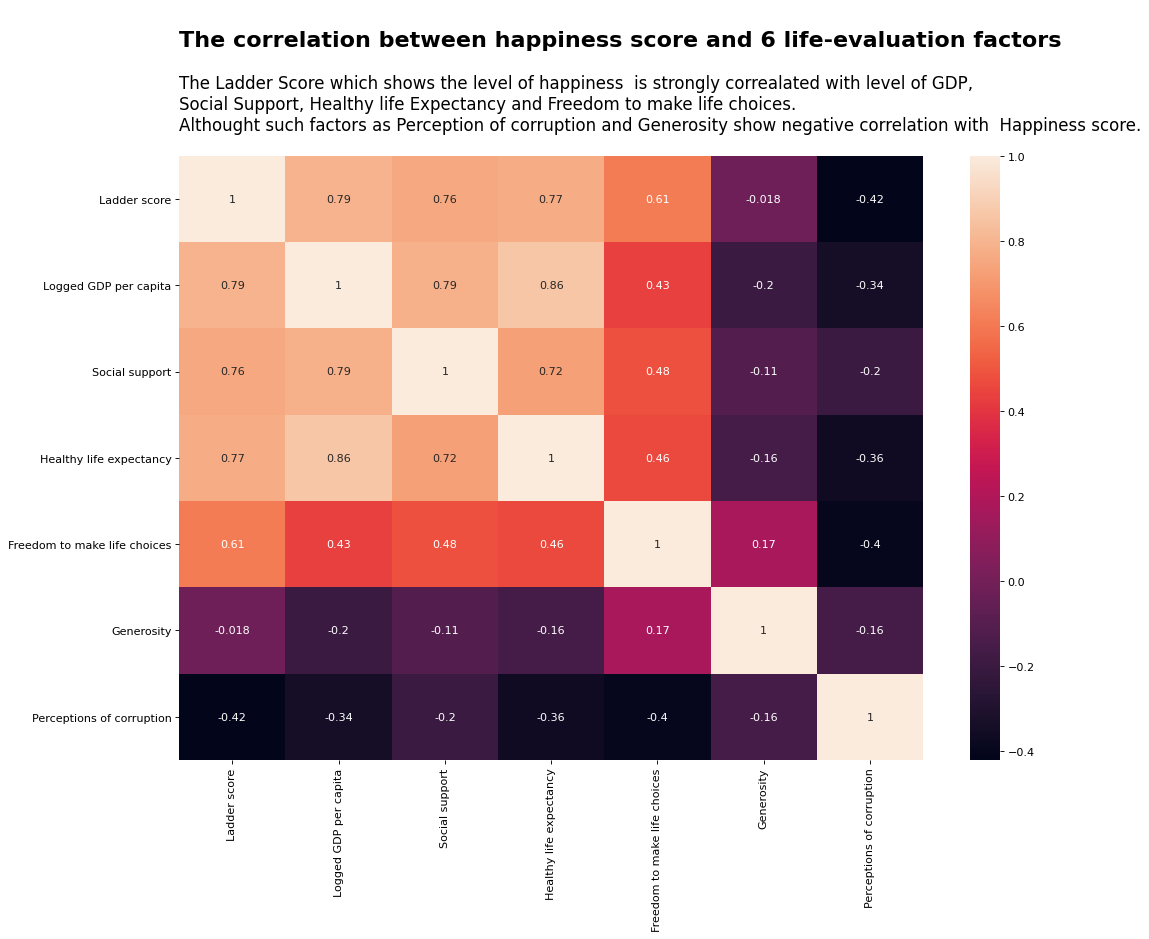

In [7]:
fig, ax = plt.subplots(1,1, figsize=(15, 10),dpi=80)

sns.heatmap(data[maincols].corr(),annot=True)

#plt.title("\nThe correlation between happiness score and 6 life-evaluation factors\n",           fontsize = 18, fontweight ='bold' )

ax.text(0,-1, "\nThe correlation between happiness score and 6 life-evaluation factors\n", 
          fontsize = 20, fontweight ='bold')
ax.text(0,-0.3,'The Ladder Score which shows the level of happiness  is strongly correalated with level of GDP, \
            \nSocial Support, Healthy life Expectancy and Freedom to make life choices.\
            \nAlthought such factors as Perception of corruption and Generosity show negative correlation with  Happiness score.',
        fontsize=15)

plt.show()

# Happy and Unhappy countries

Worldwide happiness comes in at an average score of 5.5.

To analyse the differences between those who are happy and who are not.


**Let's devide all countries into 2 groups:**
1. 'happy group' -  countries with happiness score  above average > 5.5328 
2. 'unhappy group' - countries with happiness score  below average < 5.5328


**How many countries and people live above and below median happiness score(5.5328)?**

In [8]:
#add POPULATION to data and analise it

data_pop = pd.merge(data, pop, how = 'left', on = 'Country name') 
data_pop['Population_m'] = (data_pop['Population2020']/1000000).round(3)
data_pop = data_pop.drop(columns = ['Population2020'])

#population data preprocessing

#group by mean score for pieplots - to show not only %% but also value
groupby_score_mean_pop = data_pop.groupby('groupby meanscore')['Population_m'].sum().sort_values()
groupby_score_mean_cntry = data_pop.groupby('groupby meanscore')['Country name'].count().sort_values(ascending =False)

#add col Population to main cols  &&!&&!&!??? del&
maincols_pop = maincols
maincols_pop.append('Population_m')

#change columns Med age, Fert rate -type from object to float
data_pop = data_pop.astype({'Med. Age': 'float'})
data_pop = data_pop.astype({'Fert. Rate': 'float'})

#means to analyze
mean_urban = data_pop['UrbanPop%'].mean()
mean_fert = data_pop['Fert. Rate'].mean()
mean_age = data_pop['Med. Age'].mean()
total_pop = data_pop['Population_m'].sum()


#data_pop.info()

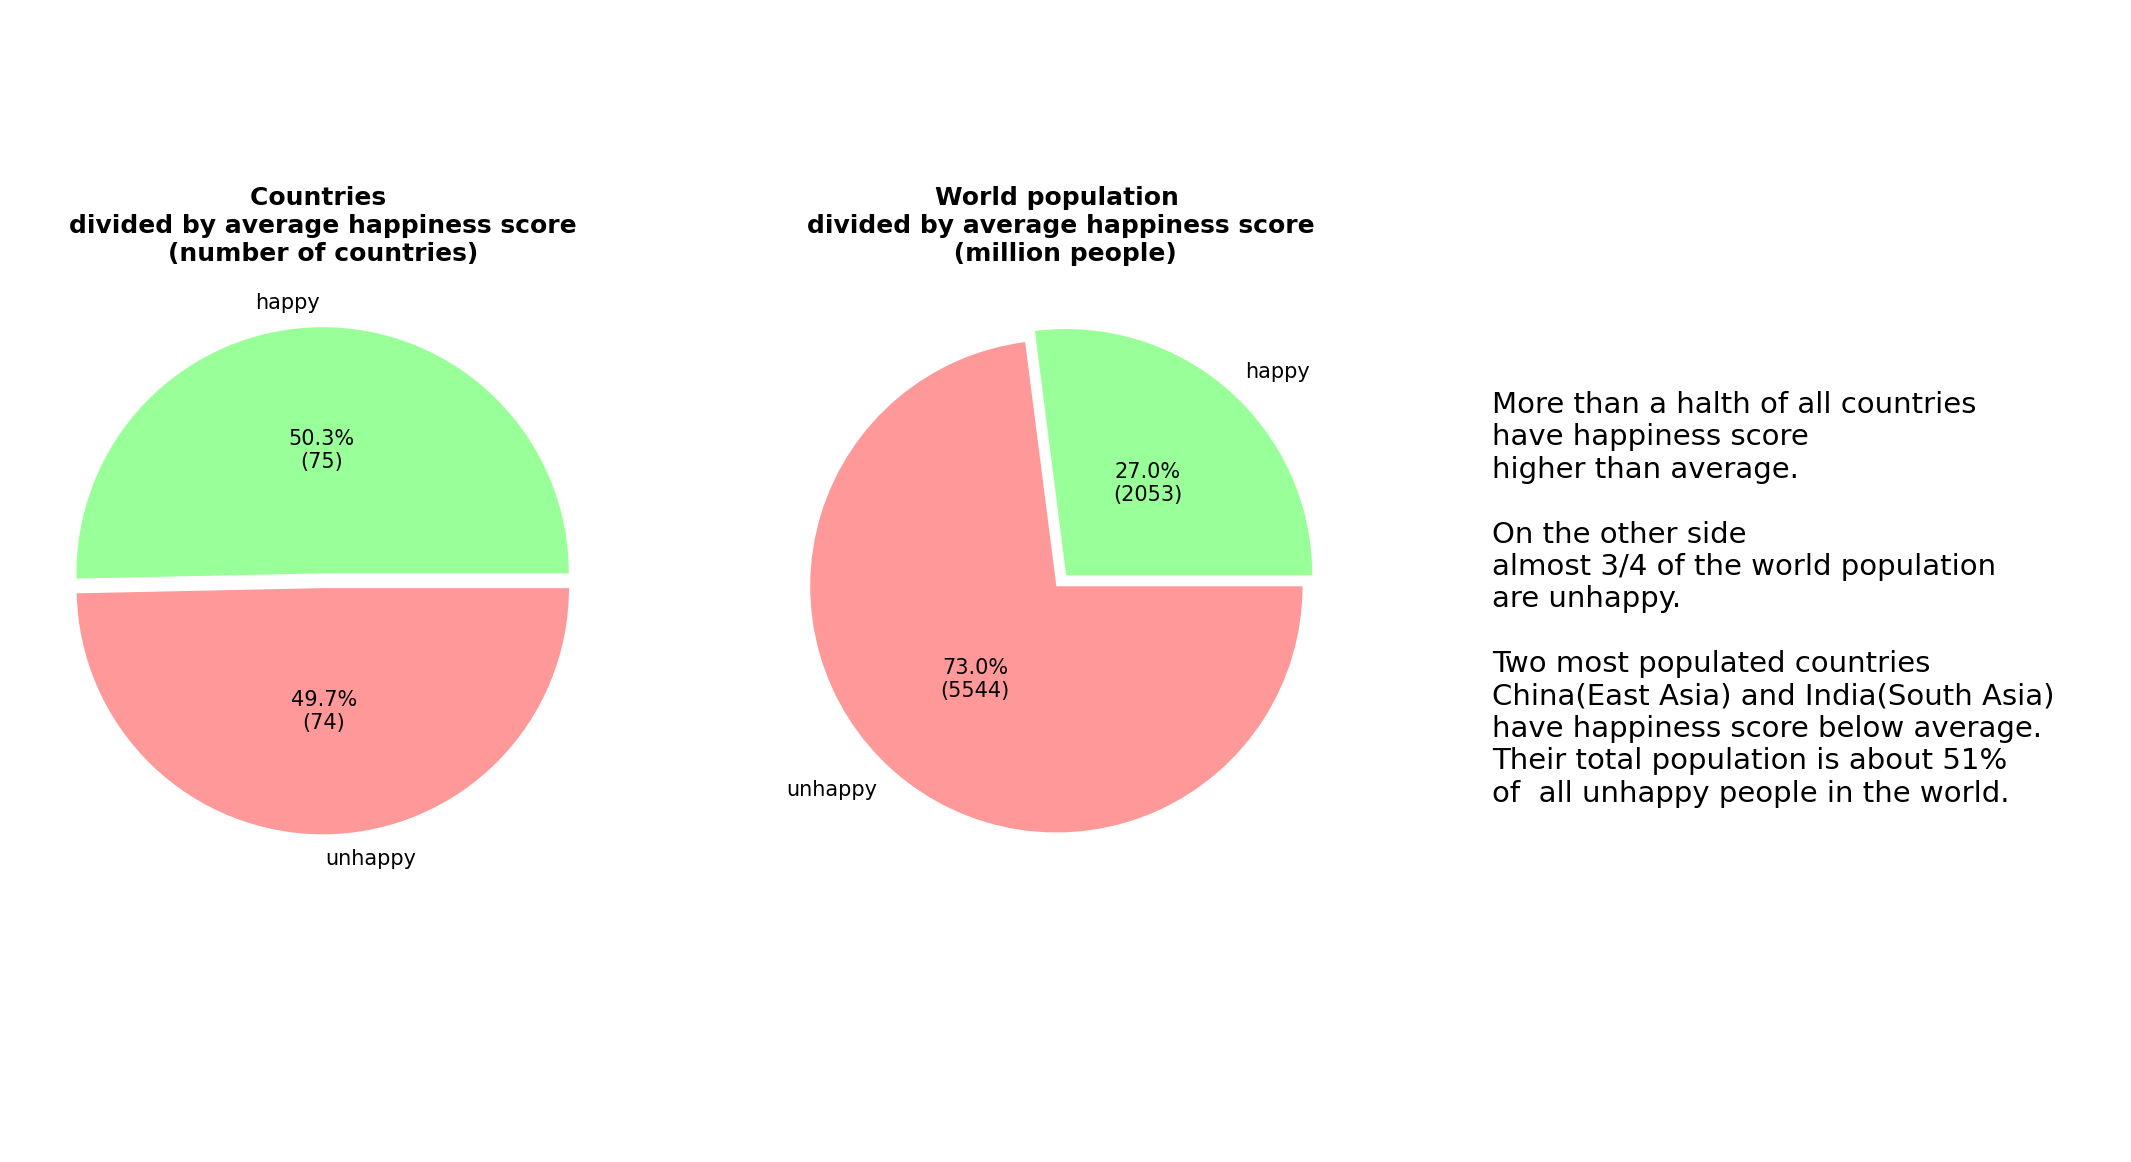

In [9]:
#Pie Chart shows the population in each happiness _group 


#The mean ladder score is 5.532839 Lets see how many countries and  people live above and below median

fig, axs = plt.subplots(1,3, figsize=(18, 10), dpi = 150 )

labels = ['happy', 'unhappy']
explode=[0.03]*2
colors = ['#99ff99', '#ff9999'] #Mint Green, lightsalmonpink

def fu(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals))) 
    return "{:.1f}%\n({:.0f})".format(pct, absolute)


axs[0].pie(groupby_score_mean_cntry,  explode=explode,  pctdistance=0.5, labels = labels, colors=colors,
          autopct=lambda pct: fu(pct, groupby_score_mean_cntry) ) #autopct= '%1.1f%%',
axs[0].set_title('Countries \ndivided by average happiness score\n(number of countries)',  fontweight = 'bold')
axs[1].pie(groupby_score_mean_pop,  explode=explode,  pctdistance=0.5, labels = labels,colors=colors,
          autopct=lambda pct: fu(pct, groupby_score_mean_pop))  #autopct="%.1f%%",
axs[1].set_title('World population \ndivided by average happiness score\n (million people)', fontweight = 'bold')

axs[2].text(0,0.3,'More than a halth of all countries \nhave happiness score \nhigher than average.\n\
    \nOn the other side \nalmost 3/4 of the world population\nare unhappy.\n\
    \nTwo most populated countries \nChina(East Asia) and India(South Asia) \nhave happiness score below average.\
        \nTheir total population is about 51%  \nof  all unhappy people in the world.',\
                        fontweight='normal',fontsize=14, weight='light',color='black', va ='bottom')

       


axs[2].set_yticklabels('')
axs[2].set_xticklabels('')
axs[2].tick_params(axis='y',length=0)
axs[2].tick_params(axis='x',length=0)
for line in ['top','right','left','bottom']:
    axs[2].spines[line].set_visible(False)

plt.show()

***

**Happiness and 6 factors of life evaluation**

Happiness levels depend not just on financial security, but also broader perceptions of one’s social support, personal freedom, and more. 

The plots below show the  extent to which each of six factors  estimated to contribute to making life evaluations higher in every  country.

***

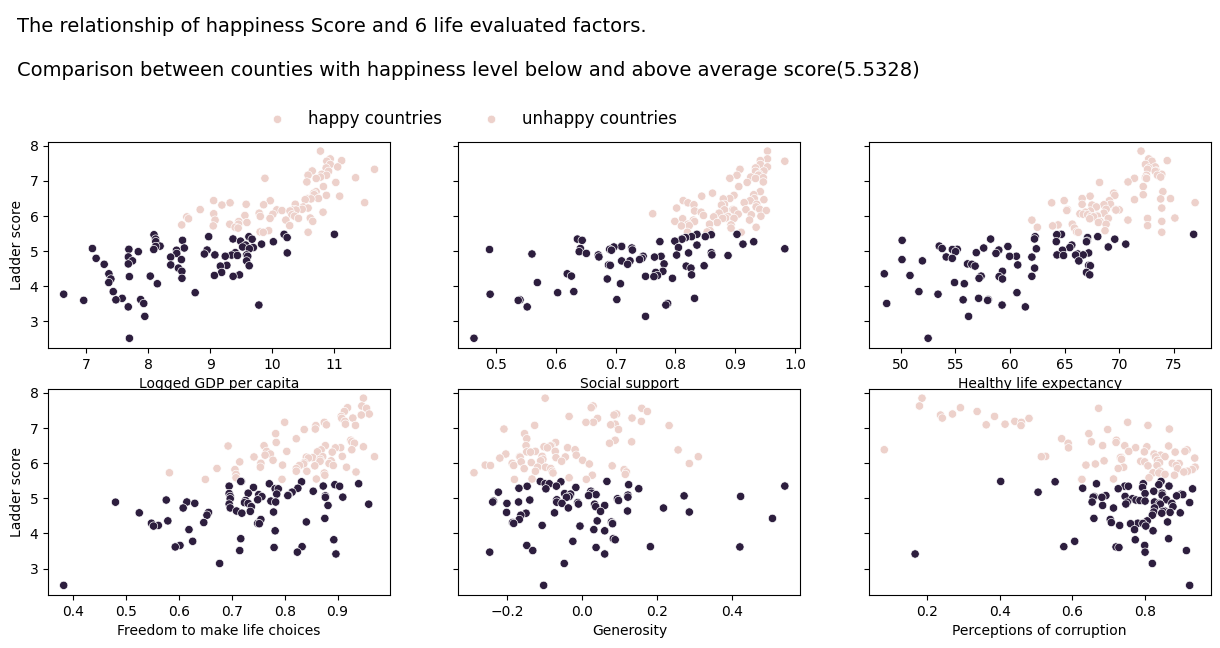

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharey=True, dpi = 100 )


sns.scatterplot(ax = axes[0,0], y ='Ladder score',  x ='Logged GDP per capita', \
                hue = 'groupby meanscore', data = data, legend = False)
sns.scatterplot(ax = axes[0,1], y ='Ladder score',  x ='Social support', \
                hue = 'groupby meanscore', data = data, legend = False)
sns.scatterplot(ax = axes[0,2], y ='Ladder score',  x ='Healthy life expectancy', \
                hue = 'groupby meanscore', data = data, legend = False)
sns.scatterplot(ax = axes[1,0], y ='Ladder score',  x ='Freedom to make life choices', \
                hue = 'groupby meanscore', data = data, legend = False)
sns.scatterplot(ax = axes[1,1], y ='Ladder score',  x ='Generosity', \
                hue = 'groupby meanscore', data = data, legend = False)
sns.scatterplot(ax = axes[1,2], y ='Ladder score',  x ='Perceptions of corruption', \
                hue = 'groupby meanscore', data = data, legend = False)


fig.legend(loc='upper left', bbox_to_anchor= (0.1,1.1), ncol=2,\
           borderaxespad=0, frameon=False, title_fontsize=14, fontsize=12,
          title='The relationship of happiness Score and 6 life evaluated factors.\n\
          \nComparison between counties with happiness level below and above average score(5.5328)\n', \
           labels=["happy countries", 'unhappy countries'] )


plt.show()

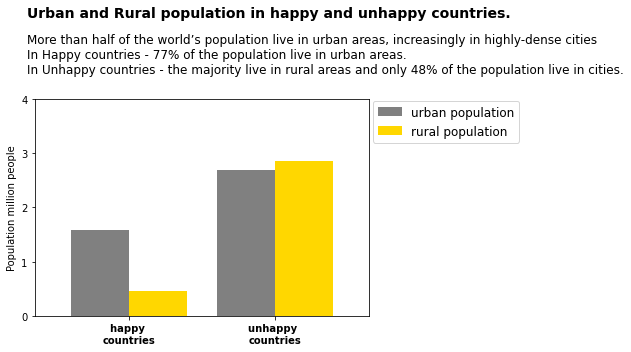

In [11]:
plt.figsize=(20,20)
df =data_pop


df.groupby('groupby meanscore')\
        .agg(total_urban=('UrbanPopMln','sum'),total_rural=('RuralPopMln','sum'))\
        .plot(kind='bar',width = 0.8, color=('gray','gold'))


plt.text(-0.7,5500,'Urban and Rural population in happy and unhappy countries.', fontsize = 14, fontweight = 'bold')

plt.text(-0.7,4200,'\nMore than half of the world’s population live in urban areas, increasingly in highly-dense cities\
\nIn Happy countries - 77% of the population live in urban areas. \
\nIn Unhappy countries - the majority live in rural areas and only 48% of the population live in cities.\n',
        fontsize = 12)

plt.legend(loc='upper left', bbox_to_anchor= (1.01,0.99), ncol=1,\
           borderaxespad=0, frameon=True, title_fontsize=14, fontsize=12,
          
           labels=["urban population", 'rural population'] )
plt.ylabel('Population million people')
plt.xlabel('')

plt.yticks([0,1000,2000,3000,4000], [0,1,2,3,4])
plt.xticks([0,1], ['happy \ncountries','unhappy \ncountries'], rotation = 0, fontweight = 'bold')

plt.show()

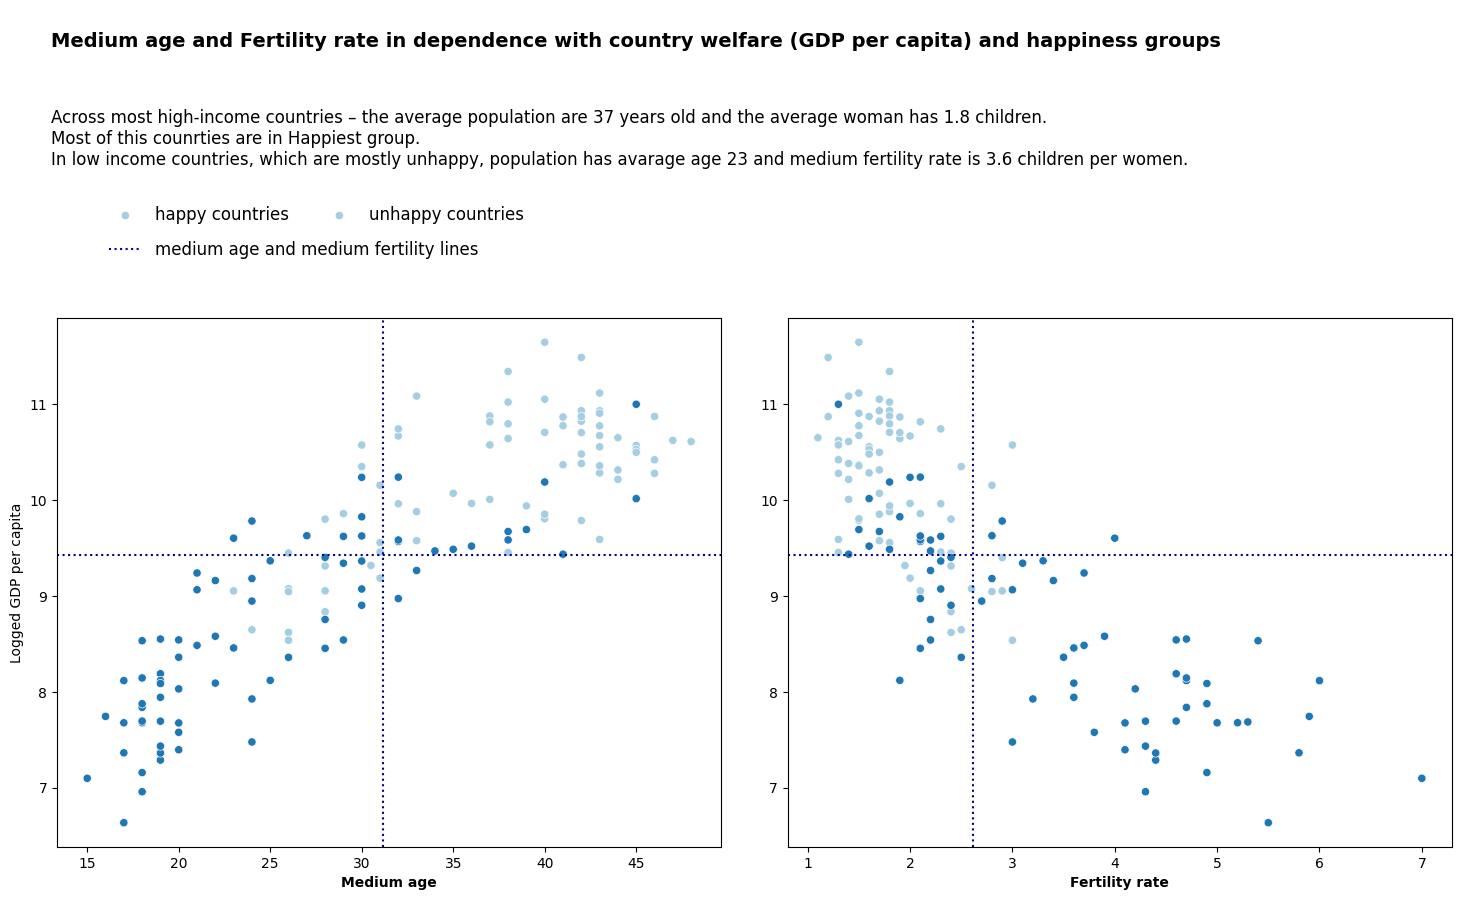

In [12]:
data = data_pop

fig = plt.figure(figsize=(18,7), dpi =100)
#widths = [2, 2]


gs = fig.add_gridspec(ncols = 2, nrows = 1)#, width_ratios=widths)
gs.update(wspace=0.1, hspace=0.2)  # <--- wwigth between  cells og the fig (figure)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

# Remove border from plot
#for s in ['top', 'bottom', 'right']:    
   # ax0.spines[s].set_visible(False)
   # ax1.spines[s].set_visible(False)
    
# ax labels off
#ax0.axes.get_xaxis().set_ticks([])
#ax0.axes.get_yaxis().set_ticks([])
#ax1.axes.get_xaxis().set_ticks([])
#ax1.axes.get_yaxis().set_ticks([])


sns.scatterplot( ax = ax0, y ='Logged GDP per capita',  x ='Med. Age', \
                hue = 'groupby meanscore', data = data, legend = False, palette = 'Paired')
sns.scatterplot( ax = ax1, y ='Logged GDP per capita',  x ='Fert. Rate', \
                hue = 'groupby meanscore', data = data, legend = False, palette = 'Paired')

ax0.set_xlabel('Medium age', fontweight = 'bold')     
ax1.set_xlabel('Fertility rate', fontweight = 'bold')     
ax1.set_ylabel('') 


fig.legend(loc='upper left', bbox_to_anchor= (0.15,1.05), ncol=2,\
           borderaxespad=0, frameon=False,  fontsize=12,
           labels=["happy countries", 'unhappy countries'] )

line_col = 'darkblue'
ax0.axvline(mean_age, ls=':', c=line_col)
ax0.axhline(mean_gdp, ls=':',  c=line_col)
ax1.axvline(mean_fert, ls=':',  c=line_col)
ax1.axhline(mean_gdp, ls=':',  c=line_col)

fig.legend(loc='upper left', bbox_to_anchor= (0.15,1), ncol=1,\
           borderaxespad=0, frameon=False, fontsize=12,
                     labels=["medium age and medium fertility lines"] )
ax0.text(13,14.5,'\nMedium age and Fertility rate in dependence with country welfare (GDP per capita) and happiness groups\n', 
         fontsize=14, fontweight ='bold')
ax0.text(13,13.5,
         'Across most high-income countries – the average population are 37 years old and the average woman has 1.8 children.\
         \nMost of this counrties are in Happiest group.\
         \nIn low income countries, which are mostly unhappy, population has avarage age 23 and medium fertility rate is 3.6 children per women.',
        fontsize = 12)

plt.show()

In [13]:
#lETS CHECK THE CORRELATION WITH POLITICS

all_data = pd.merge(data_pop, regime[['Country name','Type', 'Subtype']], how = 'left', on ='Country name')
all_data.shape


#preprocessing categorical data: Type and Subtype of regime to check their correlation with Happiness score

def sub_regime_rank(val):    
    if val   == 'Parliamentary Democracy':       return 6
    elif val == 'Semi-Presidential Democracy':   return 5
    elif val == 'Presidential Democracy':        return 4
    elif val == 'Royal Dictatorship':            return 3
    elif val == 'Civilian Dictatorship':         return 2
    elif val == 'Military Dictatorship':         return 1
    else:                                        return 0

def regime_rank(val):    
    if val   == 'Democracy':       return 1
    elif val == 'Dictatorship':    return 0
    else:                          return 9999


all_data['regime'] = all_data['Type'].apply(regime_rank)
all_data['sub_regime'] = all_data['Subtype'].apply(sub_regime_rank)

# groups according political regime and mean happiness level
regime_group = all_data.groupby(['Type','Subtype','groupby meanscore']).agg(count = ('Country name','count'))
regime_group['%'] = regime_group['count'].div(regime_group['count'].sum(level = 0), level=0)                                   
regime_group['%'] = (regime_group['%']*100).round(0) 
#regime_group

# Politics
One of the main aim of this stydy is to examine the  role of political institutions in explaining  happiness level.

All countries are devided into 2 main types: **Democtaracy** and **Dictatorship** and 6 subtypes

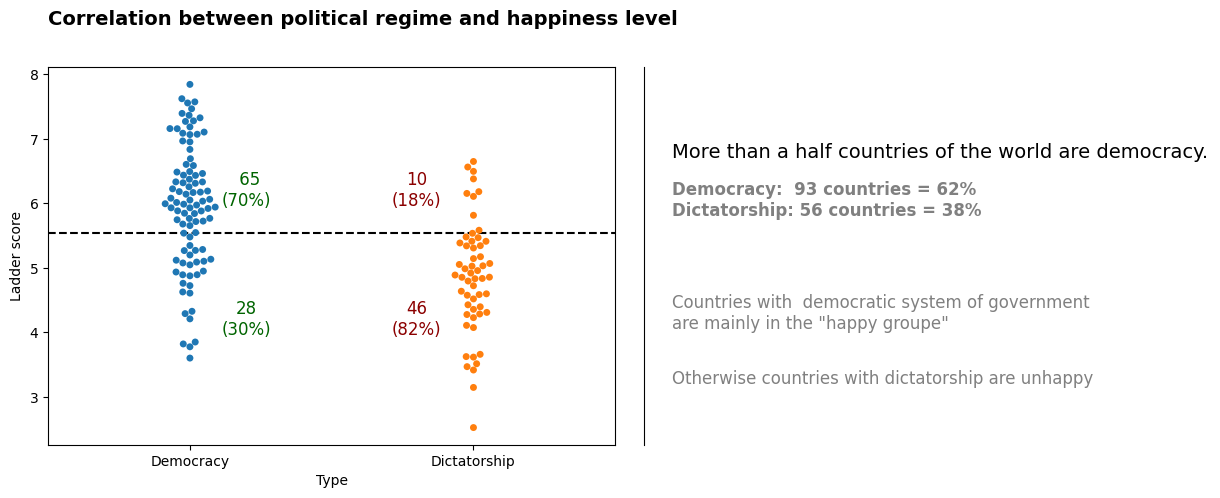

In [14]:
fig = plt.figure(figsize=(15,5),dpi=100)
widths = [2, 2]

gs = fig.add_gridspec(ncols = 2, nrows = 1, width_ratios=widths)
gs.update(wspace=0.05, hspace=0.27)  # <--- wwigth between  cells og the fig (figure)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

# Remove border from plot
#for s in ['top', 'bottom', 'left']:
   # ax0.spines[s].set_visible(False)
    
for s in ['top', 'bottom', 'right']:    
    ax1.spines[s].set_visible(False)
    

ax1.axes.get_xaxis().set_ticks([])
ax1.axes.get_yaxis().set_ticks([])

sns.swarmplot(x= all_data['Type'],  y= all_data['Ladder score'], ax = ax0)
ax0.axhline(5.532839, ls='--', c='black')


ax0.text(-0.5,9,'Correlation between political regime and happiness level',
         fontfamily='sans-serif',fontsize=14,fontweight='bold',color='black',
        horizontalalignment='left',  verticalalignment='top') 

ax0.text(0.2,6.5,' 65\n(70%)',
         fontfamily='sans-serif',fontsize=12,fontweight='normal',color='darkgreen',
        horizontalalignment='center',  verticalalignment='top')

ax0.text(0.2,4.5,'28\n(30%)',
         fontfamily='sans-serif',fontsize=12,fontweight='normal',color='darkgreen',
        horizontalalignment='center',  verticalalignment='top')

ax0.text(0.8,6.5,'10\n(18%)',
         fontfamily='sans-serif',fontsize=12,fontweight='normal',color='darkred',
        horizontalalignment='center',  verticalalignment='top')

ax0.text(0.8,4.5,'46\n(82%)',
         fontfamily='sans-serif',fontsize=12,fontweight='normal',color='darkred',
        horizontalalignment='center',  verticalalignment='top')



ax1.text(0.05,0.8,'More than a half countries of the world are democracy.',
         fontfamily='sans-serif',fontsize=14,fontweight='normal',color='black',
        horizontalalignment='left',  verticalalignment='top') 

ax1.text(0.05,0.7,'Democracy:  93 countries = 62%\
                \nDictatorship: 56 countries = 38%',
         fontfamily='sans-serif',fontsize=12,fontweight='bold',color='gray',
        horizontalalignment='left',  verticalalignment='top') 

ax1.text(0.05,0.4,'Countries with  democratic system of government \nare mainly in the "happy groupe"',
         fontfamily='sans-serif',fontsize=12,fontweight='normal',color='gray',
        horizontalalignment='left',  verticalalignment='top') 

ax1.text(0.05,0.2,'Otherwise countries with dictatorship are unhappy',
         fontfamily='sans-serif',fontsize=12,fontweight='normal',color='gray',
        horizontalalignment='left',  verticalalignment='top') 



plt.show()

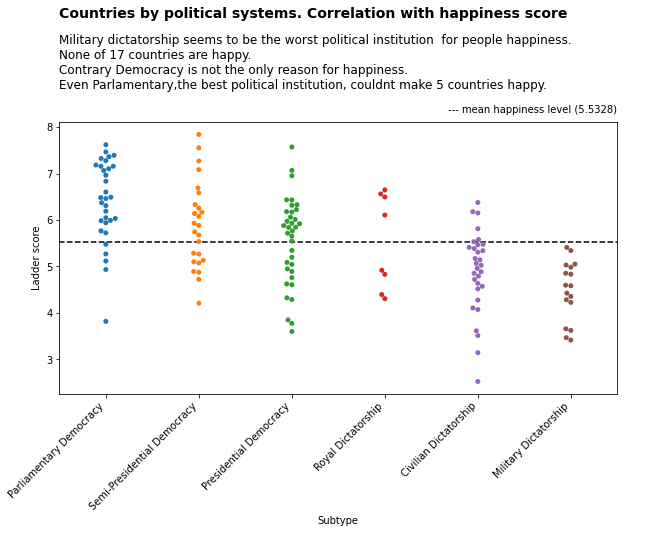

In [15]:
all_data = all_data.sort_values('sub_regime', ascending =False)
fig = plt.figure(figsize=(10,5))
types = sns.swarmplot(x= all_data['Subtype'],
              y= all_data['Ladder score'])

types.axhline(5.532839, ls='--', c='black')

types.set_xticklabels(types.get_xticklabels(),rotation=45, horizontalalignment='right')
plt.text(-0.5, 10, 'Countries by political systems. Correlation with happiness score\n',fontsize=14,fontweight='bold')
plt.text(5.5,8.3, '--- mean happiness level (5.5328)',horizontalalignment='right' )


plt.text(-0.5,10, 'Military dictatorship seems to be the worst political institution  for people happiness. \
                \nNone of 17 countries are happy. \
                \nContrary Democracy is not the only reason for happiness. \
                \nEven Parlamentary,the best political institution, couldnt make 5 countries happy.',
        fontfamily='sans-serif',fontsize=12,fontweight='normal',color='black',
        horizontalalignment='left',  verticalalignment='top')


plt.show()

In [16]:

############################  Regional groups  ######################################

# Regional groups

Let's take a look on happiness distribution along the world. 

The world happines report distinguish 10 regional groups. 

We will analise and vizualise the possible liks between happiness level of the region and 2 life evaluated factors: population and politics.

In [17]:
#set the order of Regions according to their MEAN happiness score of the group

ri = all_data.groupby('Regional indicator',as_index=False).agg(score = ("Ladder score",'mean')).sort_values('score',ascending = False)
reg_list = list(ri['Regional indicator'])
dataset = {'Regional indicator': reg_list,
           'order':[1,2,3,4,5,6,7,8,9,10]    }
regions_order = pd.DataFrame (dataset)
all_data = pd.merge(all_data, regions_order, on = 'Regional indicator')

# count total population in each regional group
pop_reg = data_pop.groupby('Regional indicator', as_index = False)\
                .agg(total_popul =('Population_m','sum'), urbanpop = ('UrbanPopMln','sum'),  ruralpop = ('RuralPopMln','sum'),                     
                     meanscore = ('Ladder score','mean'),  maxscore = ('Ladder score','max'), minscore = ('Ladder score','min'),
                     countries = ('Country name', 'count'), GDP = ('Logged GDP per capita','mean'))\
                .sort_values(by = 'maxscore', ascending = False)
pop_reg['urban%'] = (pop_reg['urbanpop']/pop_reg['total_popul']*100).round(0)
pop_reg = pd.merge(pop_reg,regions_order, on = 'Regional indicator') 
pop_reg = pop_reg.sort_values('order')
#pop_reg


#POlitical regimes in different regional groups
dem = all_data[all_data['Type']=='Democracy'].groupby(['Regional indicator'], as_index ='Regional indicator').agg(Democracy = ('Type','count'))
dic = all_data[all_data['Type']=='Dictatorship'].groupby(['Regional indicator'], as_index ='Regional indicator').agg(Dictatorship = ('Type','count'))

regions_regime = dem.join(dic, on = 'Regional indicator', how = 'outer')
regions_regime = pd.merge(regions_regime,regions_order, how = 'left', on = 'Regional indicator')
regions_regime = regions_regime.set_index('Regional indicator')
#regions_regime
#pop_reg

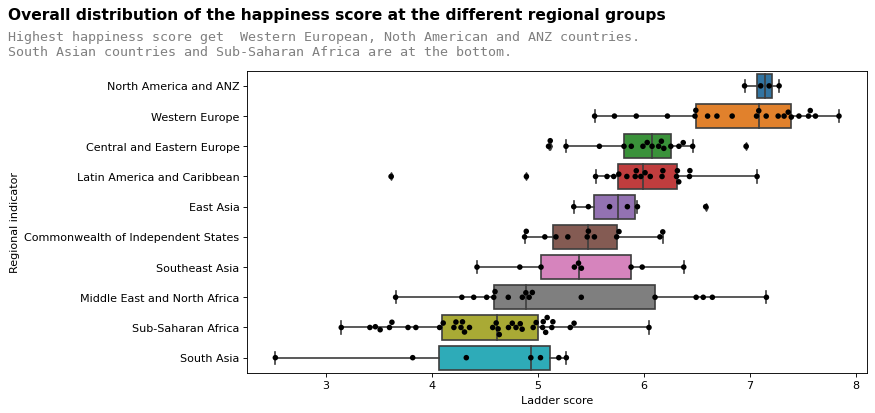

In [18]:
fig,ax = plt.subplots(1,1, figsize=(10, 5),dpi=80)

sns.boxplot(data = all_data.sort_values('order'), y = 'Regional indicator',  x = 'Ladder score')
sns.swarmplot(data = all_data.sort_values('order'), y = 'Regional indicator', x = 'Ladder score', size = 5, color = 'black' )

ax.text(0,-2.2, 'Overall distribution of the happiness score at the different regional groups',\
        fontfamily='sans-serif',fontsize=14,fontweight='bold',color='black')
ax.text(0,-1,  'Highest happiness score get  Western European, Noth American and ANZ countries.\
\nSouth Asian countries and Sub-Saharan Africa are at the bottom.',\
       fontfamily='monospace',fontsize=12,fontweight='light',color='gray')

plt.show()

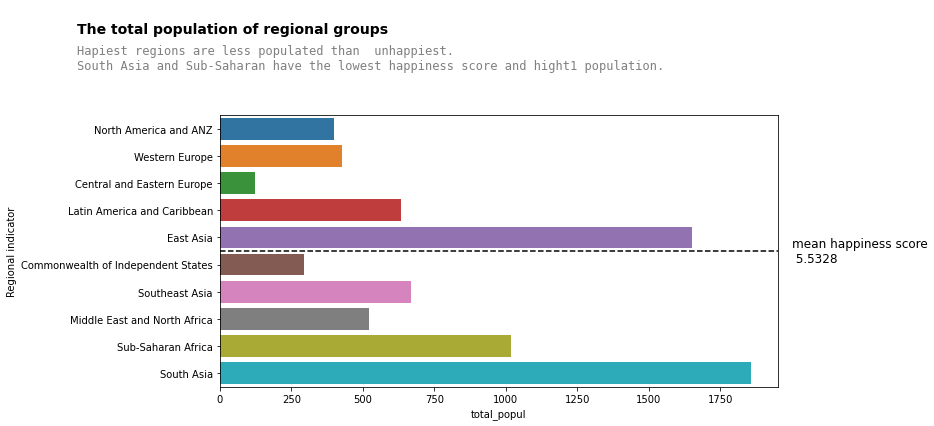

In [19]:
#  two most populated Countries - China abd India scored lower then 5.53  
#Their total poppulation is a half of entire population below average score
fig,ax = plt.subplots(1,1, figsize=(10, 5))

sns.barplot(y = pop_reg['Regional indicator'], x = pop_reg.total_popul)

ax.axhline(4.5, ls='--', c='black')
plt.text(2000,4.5, 'mean happiness score\n 5.5328', va='center', ha= 'left', fontsize = 12)

ax.text(-500,-3.5, '\nThe total population of regional groups',\
        fontfamily='sans-serif',fontsize=14,fontweight='bold',color='black')
ax.text(-500,-2.2,  'Hapiest regions are less populated than  unhappiest.\
\nSouth Asia and Sub-Saharan have the lowest happiness score and hight1 population.',\
       fontfamily='monospace',fontsize=12,fontweight='normal',color='gray')

plt.show()

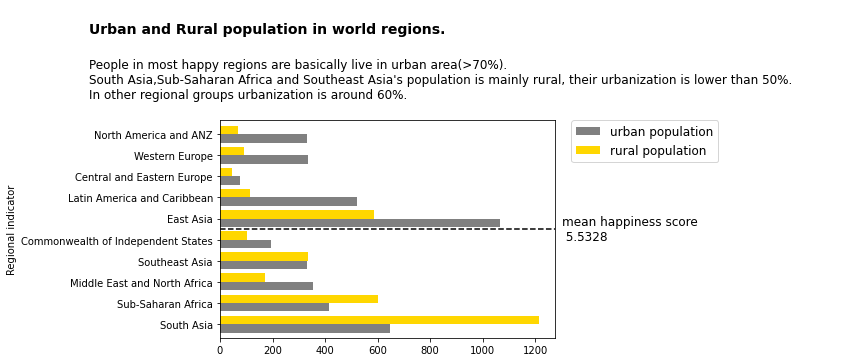

In [20]:

df = pop_reg[['Regional indicator','urbanpop', 'ruralpop','order']]
df =df.set_index('Regional indicator').sort_values('order', ascending =False)

df[['urbanpop', 'ruralpop']].plot(kind='barh',width = 0.8, color =['gray','gold'])

plt.text(-500,13,"\nUrban and Rural population in world regions.\n",
        fontsize=14,fontweight='bold')

plt.text(-500,10, "\nPeople in most happy regions are basically live in urban area(>70%).\
          \nSouth Asia,Sub-Saharan Africa and Southeast Asia's population is mainly rural, their urbanization is lower than 50%. \
          \nIn other regional groups urbanization is around 60%.\n",
        fontsize=12)
plt.legend(loc='upper left',bbox_to_anchor= (1.05,1), ncol=1,\
           borderaxespad=0, frameon=True, title_fontsize=14, fontsize=12,         
           labels=["urban population", 'rural population'] )


plt.axhline(4.5, ls='--', c='black')
plt.text(1300,4.5, 'mean happiness score\n 5.5328', va='center', ha= 'left', fontsize = 12)
plt.show()

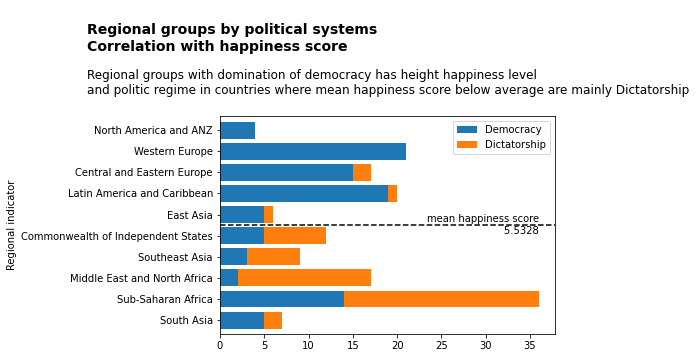

In [21]:
regions_regime.sort_values('order', ascending=False)[['Democracy','Dictatorship']].plot(kind='barh',stacked=True, 
                                                            width = 0.8)
plt.axhline(4.5, ls='--', c='black')
plt.text(36, 4.5, 'mean happiness score\n       5.5328', ha='right', va = 'center')

plt.text(-15,12,'\nRegional groups by political systems\nCorrelation with happiness score\n',fontsize=14,fontweight='bold')
plt.text(-15,10,'\nRegional groups with domination of democracy has height happiness level\
         \nand politic regime in countries where mean happiness score below average are mainly Dictatorship\n', fontsize=12)

plt.show()

In [22]:
#Finally lets compare countries at the top and the bottom of the rank

In [23]:

cols = ['Country name', 'Regional indicator', 'Ladder score', 'Logged GDP per capita', 'Social support', 
      'Healthy life expectancy','Freedom to make life choices', 'Generosity','Perceptions of corruption',
        'Population_m', 'UrbanPop%', 'UrbanPopMln', 'RuralPopMln', 'Fert. Rate', 'Med. Age',
        'Type', 'Subtype','regime','sub_regime']

top = all_data[cols].sort_values(by = 'Ladder score', ascending = False)[:10]
bottom = all_data[cols].sort_values(by = 'Ladder score',ascending = False)[-10:]


top_bottom = all_data[cols].sort_values(by = 'Ladder score')
top_bottom = pd.concat([top_bottom[:10],top_bottom[-10:]]).sort_index()
top_bottom = top_bottom.sort_values(by = 'Ladder score', ascending = True)

# Top & Bottom
Finally its time to dive deep into survey and reveal the names of happiest and unhappiest countries.
We will choose **top 10  and 10 bottom** countries from  the report according to their happiness score.



*Top 10 countries* are mainly Western Europian countries (9 of 10). New Zealand is the only non-European country to make it into the top 10 on the global happiness list. 
7 unhappiest countries in the *Bottom 10* are Sub-Saharan African countries.

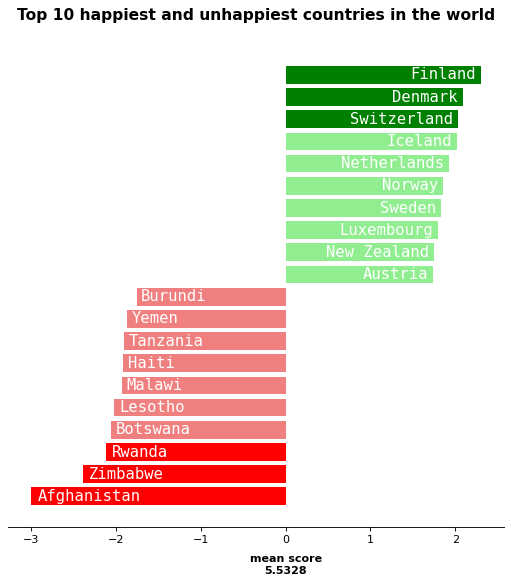

In [24]:
nameslist = list(top_bottom ['Country name'])
scoreslist = list(top_bottom ['Ladder score']- mean_score)
#print(scoreslist)  #print(nameslist)
txt_clr = 'white'
txt_wgh = 'normal'
tst_fsz = 14


fig, ax = plt.subplots(figsize=(8,8), dpi =80)
width = 0.8

bar_colors = ['lightgreen' for _ in range(20)]
bar_colors[0] = bar_colors[1] = bar_colors[2] =  'red'
bar_colors[3] = bar_colors[4] = bar_colors[5] = bar_colors[6] = bar_colors[7] = bar_colors[8] =bar_colors[9] ='lightcoral'
bar_colors[17] = bar_colors[18] = bar_colors[19] = 'green' 


ax.barh(nameslist, scoreslist, width, color=bar_colors)


#text in the bars
for i in range(10,20):
    ax.annotate(nameslist[i], 
                   xy=(scoreslist[i]-(scoreslist[i]*0.03), i), #-(scoreslist[i]*0.03) for space at the end
                   va = 'center', ha='right',fontweight=txt_wgh, fontfamily='monospace', 
                   fontsize=tst_fsz, color=txt_clr,rotation=0)
for i in range(0,10):
    ax.annotate(nameslist[i], 
                   xy=(scoreslist[i]-(scoreslist[i]*0.03), i), #-(scoreslist[i]*0.03) for space at the end
                   va = 'center', ha='left',fontweight=txt_wgh, fontfamily='monospace', 
                   fontsize=tst_fsz, color=txt_clr,rotation=0)

for s in ["top","right","left"]:
            ax.spines[s].set_visible(False)
    
ax.set_yticks([]) 
ax.text(0,-3.5,'mean score\n5.5328', ha = 'center', fontweight = 'bold')
ax.set_title('Top 10 happiest and unhappiest countries in the world\n',\
             fontsize=14,fontweight='bold',color='black')
plt.show()

Trying to find the answer on the question **what makes happiest countries happy** 

Let's  find the difference between 6 major factors, population and politics of countries in the top and bottom of the list.

The plots show:
* the big gap in happiness level between top and bottom countries, 
* less  differences in GPD, life expectancy and political regime, and 
* miserable correlation in other factors.

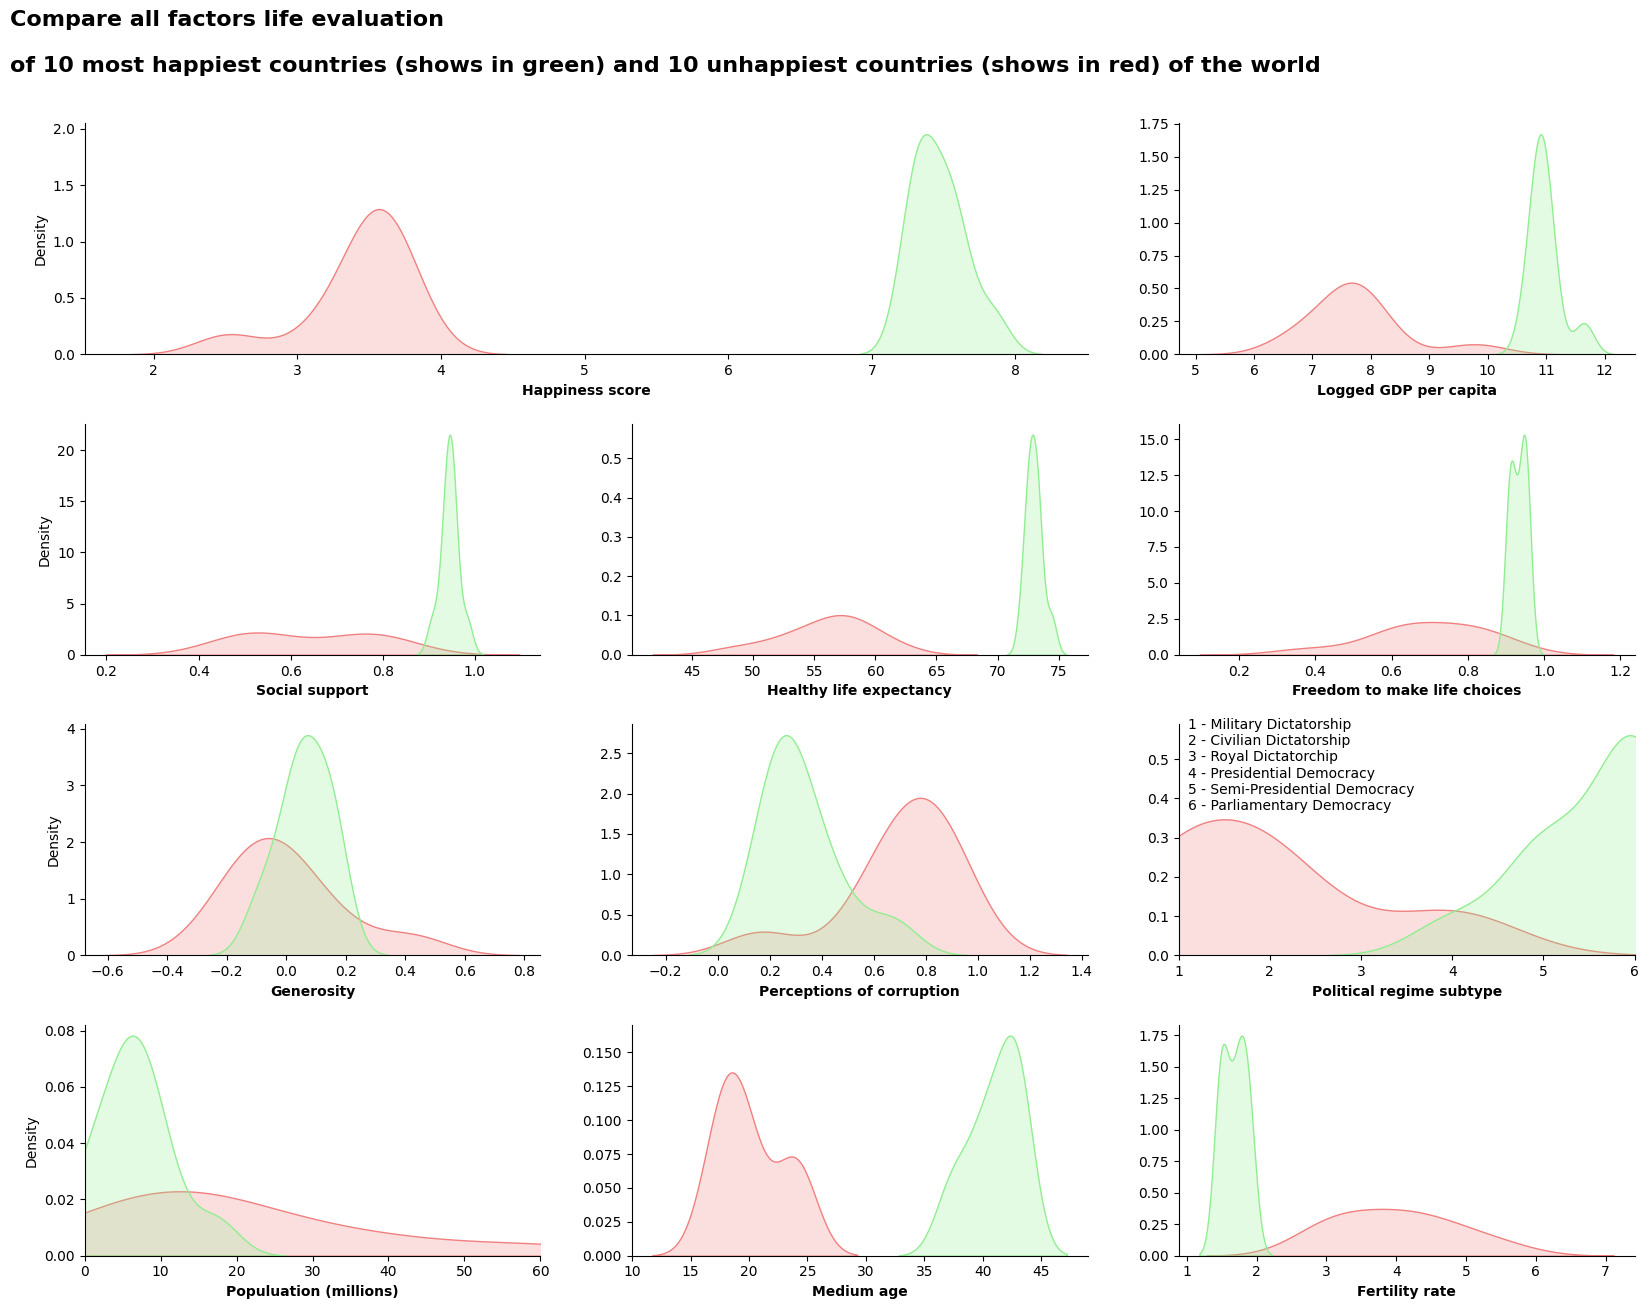

In [25]:
#name datasets
tp = top
bt = bottom

#Plot figure 
rows = 4
cols = 3
factors = ['Logged GDP per capita', 'Social support', 'Healthy life expectancy', \
       'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']

fig = plt.figure(figsize=(20, 15), dpi=100) 
gs = fig.add_gridspec(rows,cols)
gs.update(wspace=0.2, hspace=0.3)

ax1 = fig.add_subplot(gs[0,:2])
#ax1.set_title('ax1')
ax2 = fig.add_subplot(gs[0, 2])
#ax2.set_title('ax2')

for s in ["top","right"]:
        ax1.spines[s].set_visible(False)
        ax2.spines[s].set_visible(False)

sub = 3
for r in range(1,rows):
    for c in range(0,cols):
        locals()["ax"+str(sub)] = fig.add_subplot(gs[r, c])
        #locals()["ax"+str(sub)].set_title(sub)
        for s in ["top","right"]:
            locals()["ax"+str(sub)].spines[s].set_visible(False)        
        sub += 1

# TITLE the plot
ax1.text(1,2.5, 'Compare all factors life evaluation \n\
         \nof 10 most happiest countries (shows in green) and 10 unhappiest countries (shows in red) of the world',\
         fontweight = 'bold', fontsize = 16)

# fill subplot Ladder score
sns.kdeplot(data= bt,x='Ladder score',  ax =ax1, shade=True,color='lightcoral')
sns.kdeplot(data= tp,x='Ladder score',  ax =ax1, shade=True,color='lightgreen') 
ax1.set_xlabel('Happiness score', fontweight = 'bold') 


# fill subplots 6 factors
sub = 2
no_ylable = [2,4,5,7]
for f in factors:
    sns.kdeplot(data=bt, x= f, ax=locals()['ax' + str(sub)], shade=True,color='lightcoral')
    sns.kdeplot(data=tp, x= f, ax=locals()['ax' + str(sub)], shade=True,color='lightgreen')
    locals()['ax' + str(sub)].set_xlabel(f, fontweight = 'bold')
    if sub in no_ylable:
        locals()['ax' + str(sub)].set_ylabel('') 
        
    sub +=1

    
#ax8 Politics cut minus
sns.kdeplot(data=bt,x='sub_regime', ax =ax8, shade=True,color='lightcoral').set(xlim =(1,6))
sns.kdeplot(data=tp,x='sub_regime', ax =ax8 , shade=True,color='lightgreen')
ax8.set_xlabel('Political regime subtype', fontweight = 'bold')   
ax8.text(01.1,0.37, '1 - Military Dictatorship \n2 - Civilian Dictatorship \n3 - Royal Dictatorchip \
            \n4 - Presidential Democracy\n5 - Semi-Presidential Democracy\n6 - Parliamentary Democracy')
ax8.set_ylabel('') 
      
 #ax9 Population    cut minus
sns.kdeplot(data=bt,x='Population_m',  ax =ax9, shade=True,color='lightcoral').set(xlim=(0,60))
sns.kdeplot(data=tp,x='Population_m',  ax =ax9, shade=True,color='lightgreen') 
ax9.set_xlabel('Populuation (millions)', fontweight = 'bold')  
    
#ax10 Age    
sns.kdeplot(data=bt,x= 'Med. Age', ax =ax10, shade=True,color='lightcoral')
sns.kdeplot(data=tp,x= 'Med. Age', ax =ax10,  shade=True,color='lightgreen')    
ax10.set_xlabel('Medium age', fontweight = 'bold') 
ax10.set_ylabel('') 

#ax11 Fert    
sns.kdeplot(data=bt,x='Fert. Rate', ax =ax11, shade=True,color='lightcoral')
sns.kdeplot(data=tp,x='Fert. Rate', ax =ax11,  shade=True,color='lightgreen')   
ax11.set_xlabel('Fertility rate', fontweight = 'bold')     
ax11.set_ylabel('') 

plt.show()

# Compare most happiest and most unhappiest countries (Finland and Afghanistan)

We have compared entire world and top/bottom 10 countries to find  what makes people happy.

To find the measurable difference  between happy and unhgappy, we will take a look on lider and antilider of the chart.

Lets make  Finlad, the happiest country in the world to be an ethalon of happiness and take all its parameters as 100%. Then count the same factors for Afghanistan as a persentage to ideal.

As a result we will see the percentage difference for happiness.

In [26]:
# as %%% 
top_bottom ['% score'] = (top_bottom['Ladder score'] / list(top[['Ladder score']].iloc[0]) *100 ).round(0)
top_bottom ['% gpd'] = (top_bottom['Logged GDP per capita'] / list(top[['Logged GDP per capita']].iloc[0]) *100 ).round(0)
top_bottom ['% support'] = (top_bottom['Social support'] / list(top[['Social support']].iloc[0]) *100 ).round(0)
top_bottom ['% expectancy'] = (top_bottom['Healthy life expectancy'] / list(top[['Healthy life expectancy']].iloc[0]) *100 ).round(0)
top_bottom ['% freedom'] = (top_bottom['Freedom to make life choices'] / list(top[['Freedom to make life choices']].iloc[0])*100 ).round(0)
top_bottom ['% generosity'] = (top_bottom['Generosity'] / list(top[['Generosity']].iloc[0]) *100 ).round(0)

top_bottom ['% corruption'] = (((1- top_bottom['Perceptions of corruption']) / list(1- top[['Perceptions of corruption']].iloc[0])) *100 ).round(0)
top_bottom ['% population'] = (top_bottom['Population_m'] / list(top[['Population_m']].iloc[0]) *100 ).round(0)
top_bottom ['% urbanization'] = (top_bottom['UrbanPop%'] / list(top[['UrbanPop%']].iloc[0]) *100 ).round(0)
top_bottom ['% fertility'] = (top_bottom['Fert. Rate'] / list(top[['Fert. Rate']].iloc[0]) *100 ).round(0)
top_bottom ['% age'] = (top_bottom['Med. Age'] / list(top[['Med. Age']].iloc[0]) *100 ).round(0)
top_bottom ['% regime'] = (top_bottom['sub_regime'] / list(top[['sub_regime']].iloc[0]) *100 ).round(0)



#lets see the diferensec between the  MOST happiest and umhappies countries
#Finland and Afganistan

limits = pd.concat([top_bottom[:1],top_bottom[-1:]]).sort_index(ascending =False)
col_lim = ['% score','% gpd', '% support', '% expectancy',  '% freedom','% generosity','% corruption']
col_meanlim = ['mean% score','mean% gpd', 'mean% support', 'mean% expectancy',  'mean% freedom']

#limits[col_lim]
#top_bottom.head()#.columns

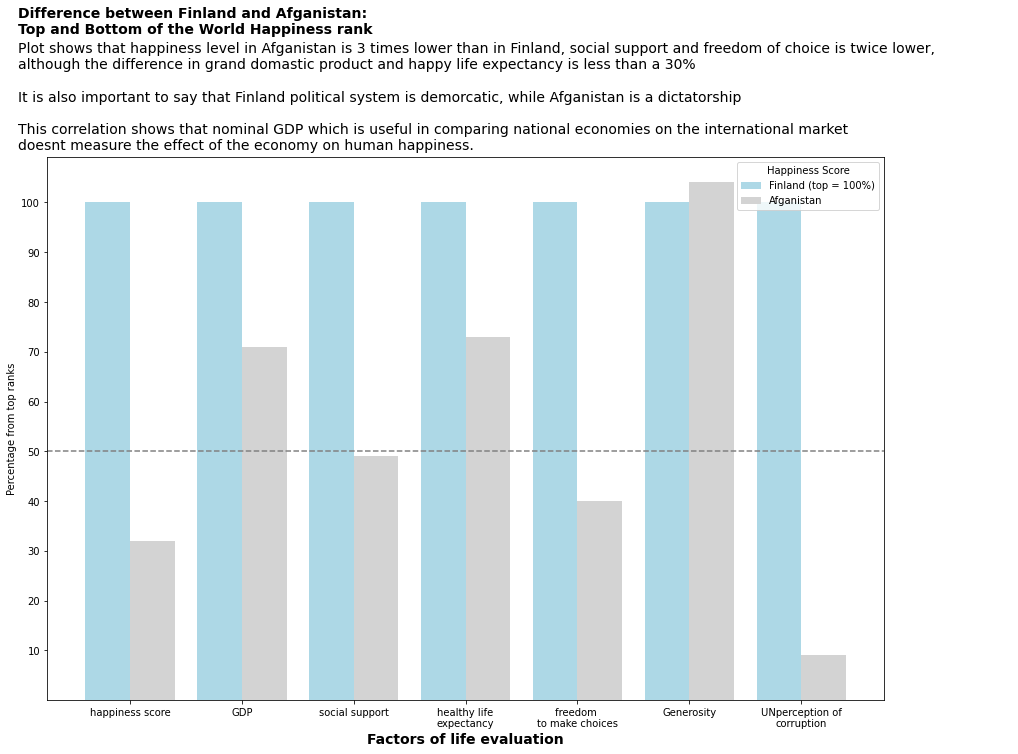

In [27]:
plt.figure(figsize=(15,10))

col_lim = ['% score','% gpd', '% support', '% expectancy',  '% freedom','% generosity','% corruption']
X = ['happiness score','GDP', 'social support', 'healthy life\nexpectancy', \
     'freedom \nto make choices', 'Generosity','UNperception of\ncorruption']

Y = limits[col_lim].iloc[0,:].values.tolist()
Z = limits[col_lim].iloc[1,:].values.tolist()


X_axis = np.arange(len(X))


plt.bar(X_axis - 0.2, Y, 0.4, label = 'Finland', color = 'lightblue')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Afghanistan', color='lightgray')

plt.xticks(X_axis, X)
plt.yticks(np.arange(10, 110, 10.0))


plt.xlabel("Factors of life evaluation", fontweight='bold', fontsize = 14)
plt.ylabel("Percentage from top ranks")
plt.text(-1,130, "Difference between Finland and Afganistan: \nTop and Bottom of the World Happiness rank\n",
          fontweight = 'bold', fontsize = 14, ha =  'left', va ='bottom'        )

plt.legend(loc='upper right', bbox_to_anchor= (1, 1), ncol=1, frameon=True,# borderaxespad=5,            
           title='Happiness Score', labels=["Finland (top = 100%)", 'Afganistan'] )


plt.text(-1,110, 'Plot shows that happiness level in Afganistan is 3 times lower than in Finland, social support and freedom of choice is twice lower, \
                \nalthough the difference in grand domastic product and happy life expectancy is less than a 30% \n\
                \nIt is also important to say that Finland political system is demorcatic, while Afganistan is a dictatorship \n\
                \nThis correlation shows that nominal GDP which is useful in comparing national economies on the international market\
                \ndoesnt measure the effect of the economy on human happiness.',
        fontsize = 14, ha= 'left', va ='bottom' )


plt.axhline(50, ls='--', c='gray')

plt.show()

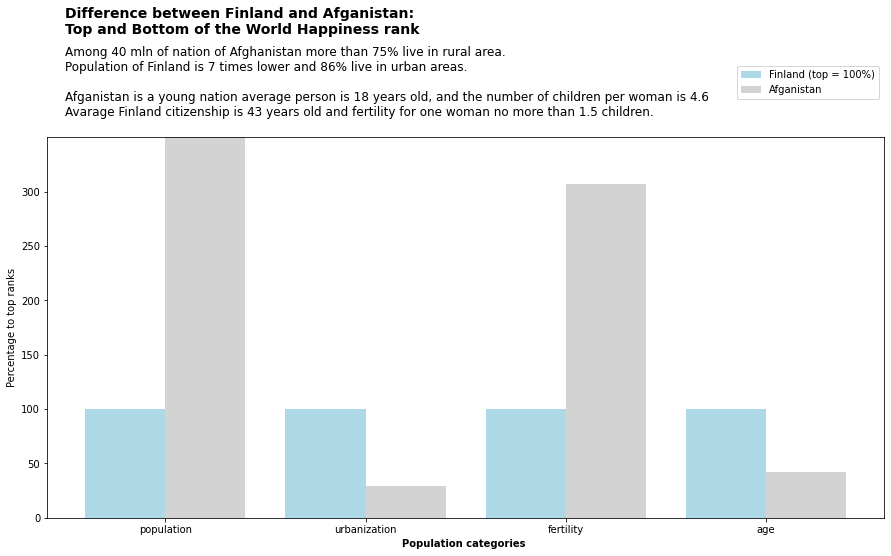

In [28]:
plt.figure(figsize=(15,7))

col_lim2 = ['% population', '% urbanization', '% fertility', '% age']
X = ['population','urbanization', 'fertility','age']
Y = limits[col_lim2].iloc[0,:].values.tolist()
Z = limits[col_lim2].iloc[1,:].values.tolist()

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, Y, 0.4, label = 'Finland', color = 'lightblue')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Afghanistan', color='lightgray')

plt.xticks(X_axis, X)
plt.yticks(np.arange(0, 350, 50.0))
plt.ylim([0, 350])

plt.xlabel("Population categories ", fontweight='bold')
plt.ylabel("Percentage to top ranks")
plt.text(-0.5,430, "Difference between Finland and Afganistan: \nTop and Bottom of the World Happiness rank\n",
          fontweight = 'bold', fontsize = 14, ha =  'left'        )

plt.legend(loc='upper right', bbox_to_anchor= (1, 1.2), ncol=1, frameon=True,# borderaxespad=5,            
           labels=["Finland (top = 100%)", 'Afganistan'] )
plt.text(-0.5,370, 'Among 40 mln of nation of Afghanistan more than 75% live in rural area.\
            \nPopulation of Finland is 7 times lower and 86% live in urban areas.\n\
            \nAfganistan is a young nation average person is 18 years old, and the number of children per woman is 4.6\
            \nAvarage Finland citizenship is 43 years old and fertility for one woman no more than 1.5 children.',
             fontsize = 12 )



plt.show()

# Values for avarage happy and unhappy
***
Finally lets drow the **general portrait of happy and unhappy countries** of the world.\
Data is based on average values for top10 and 10 bottom countries in the rank of the world happiness report.
***

In [29]:
col = ['Ladder score', 'Logged GDP per capita', 'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity','Perceptions of corruption',
       'Population_m', 'UrbanPop%', 'Fert. Rate', 'Med. Age', 'regime','sub_regime']

bottom_trans = bottom[col].describe().T[['mean']].round(2).reset_index()
bottom_trans = bottom_trans.rename(columns={'mean':'Unhappy country', 'index':'indicator'})
top_trans = top[col].describe().T[['mean']].round(2).reset_index()
top_trans  = top_trans .rename(columns={'mean':'Happy country',  'index':'indicator'})

gen = pd.merge(top_trans,bottom_trans, on = 'indicator')

zero = [0,1,3,8,10]
one  = [2,4,6,7,9]
gen.iloc[zero,1:3] = (gen.iloc[zero,1:3]).round(0)
gen.iloc[one,1:3] = (gen.iloc[one,1:3]).round(1)
gen.iloc[5,1] = (gen.iloc[5,1]).round(2)
gen.iloc[5,2] = (gen.iloc[5,2]).round(4)

gen[gen['indicator'] == 'sub_regime'] = gen[gen['indicator'] == 'sub_regime'].replace({'Happy country': 5.5}, 'Parliamentary Democracy')
gen[gen['indicator'] == 'sub_regime'] = gen[gen['indicator'] == 'sub_regime'].replace({'Unhappy country': 2.0}, 'Civilian Dictatorship')
gen[gen['indicator'] == 'regime'] = gen[gen['indicator'] == 'regime'].replace({'Happy country': 1}, 'Democracy')
gen[gen['indicator'] == 'regime'] = gen[gen['indicator'] == 'regime'].replace({'Unhappy country': 0.2}, 'Dictatorship')

gen = gen.astype({'Happy country': 'object'})
#gen

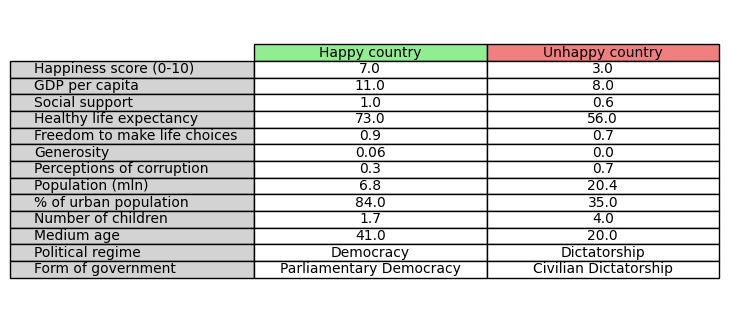

In [30]:
fig, ax =plt.subplots(1,1, dpi = 100)
#ax.axis('tight') #Set the limits, just large enough to show all the data, then disable further autoscaling.
ax.axis('off') #Turn off axis lines and labels. Same as ''False''.

df = gen[['Happy country', 'Unhappy country']]
cols = ['Happiness score (0-10)', 'GDP per capita', 'Social support',  'Healthy life expectancy',
 'Freedom to make life choices',  'Generosity',  'Perceptions of corruption',
 'Population (mln)',  '% of urban population', 'Number of children',  'Medium age',
 'Political regime', 'Form of government']
ax.table(cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        rowLabels=cols,
        rowColours =["lightgray"] * 13,  
        colColours =['lightgreen','lightcoral'] ,
        loc="center", )

plt.show()

# Conclusion

We have broaded the 6 major factors of World happiness report by population and politics ststistic.
We uncover the  scores of 149 countries,  which ones emerged the happiest or unhappiest. 
We also look at the most and least happy  countries in the world and summurize the features of happiness.

Finally, we may conclude\ 
Such clear indicators as health and wealth, can help you live a relatively happy, comfortable life
However, there’s much more to it than that. Happiness levels depend not just on financial security, but also broader perceptions of one’s social support, personal freedom and political regime of the country.